In [241]:
# importing relevant modules
import matplotlib.pyplot   as plt

from pandas                import read_csv, to_datetime
from numpy                 import reshape
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models          import Sequential
from keras.layers          import Dense, Dropout, LSTM

%matplotlib inline

In [242]:
# Currency conversion.
Yen_To_USD = lambda p: p*0.0094

In [243]:
# Import the dataset and encode the date
dataFiles     = ['bitflyerJPY_1-min_data_2017-07-04_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv',
                 'coincheckJPY_1-min_data_2014-10-31_to_2018-03-27.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv']
file          = 0
df            = read_csv('../data/' + dataFiles[file])
# Append 'date' column to our dataframe.
df['date']    = to_datetime(df['Timestamp'],unit='s').dt.date
# Store the average weighted price per day.
daily_average = [df.groupby('date')['Weighted_Price'].mean().apply(Yen_To_USD), df.groupby('date')['Weighted_Price'].mean()][file%2]

In [244]:
# Split data
#Train on (1-data_split)*100% of the data and test on data_split*100 of the data.
data_split        = 0.1
prediction_days   = int(len(daily_average)*data_split)
df_train, df_test = daily_average[:-prediction_days], daily_average[-prediction_days:]
df_train

date
2017-07-04     2746.469033
2017-07-05     2731.289148
2017-07-06     2755.915730
2017-07-07     2723.025962
2017-07-08     2718.239340
2017-07-09     2733.253814
2017-07-10     2668.537385
2017-07-11     2544.796174
2017-07-12     2516.631219
2017-07-13     2540.765586
2017-07-14     2456.721071
2017-07-15     2187.655102
2017-07-16     2061.827502
2017-07-17     2172.921031
2017-07-18     2419.739191
2017-07-19     2431.979533
2017-07-20     2590.612287
2017-07-21     2761.404772
2017-07-22     2843.413920
2017-07-23     2866.214166
2017-07-24     2871.894032
2017-07-25     2765.271239
2017-07-26     2648.376925
2017-07-27     2710.244357
2017-07-28     2870.390048
2017-07-29     2861.415826
2017-07-30     2842.835269
2017-07-31     2936.213860
2017-08-01     2925.263676
2017-08-02     2845.313876
                  ...     
2018-01-31    10250.872855
2018-02-01     9748.177655
2018-02-02     8583.779017
2018-02-03     9017.107694
2018-02-04     8809.853943
2018-02-05     7840.930

We can see, from above, that the training data set has no entries after the last date shown above. We will now perform min-max normalization on the training data and then construct an LSTM network to make predictions for the remainder of our data. After this, we will compare our model's predicted price values to that of the testing data set.

In [245]:
# Form training set from daily averages.
training_set = df_train.values
training_set = reshape(training_set, (len(training_set), 1))

# Perform Min-max normalization.
sc           = MinMaxScaler()
training_set = sc.fit_transform(training_set)

# Create two new arrays, x is a day behind y.
x_train      = training_set[:-1]
y_train      = training_set[1:]
x_train      = reshape(x_train, (len(x_train), 1, 1))

In [246]:
# Building the model
lstm_units = 100
model      = Sequential()

model.add(LSTM(units            = lstm_units,
               return_sequences = True,
               input_shape      = (None, 1)))

model.add(Dropout(0.2))
    
model.add(LSTM(units            = lstm_units,
               return_sequences = False))

model.add(Dropout(0.2))

model.add(Dense(units      = 1,
                activation = 'linear'))

model.compile(loss      = 'mean_squared_error',
              optimizer = 'rmsprop')

model.summary()

# Fitting the RNN to the Training set
history = model.fit(x_train,
                    y_train,
                    batch_size = len(x_train),
                    epochs     = 100,
                    verbose    = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, None, 100)         40800     
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [247]:
# Predicting the future.
actual_prices       = df_test.values
inputs              = reshape(sc.transform(reshape(actual_prices, (len(actual_prices), 1))), (len(actual_prices), 1, 1))
predicted_BTC_price = sc.inverse_transform(model.predict(inputs))

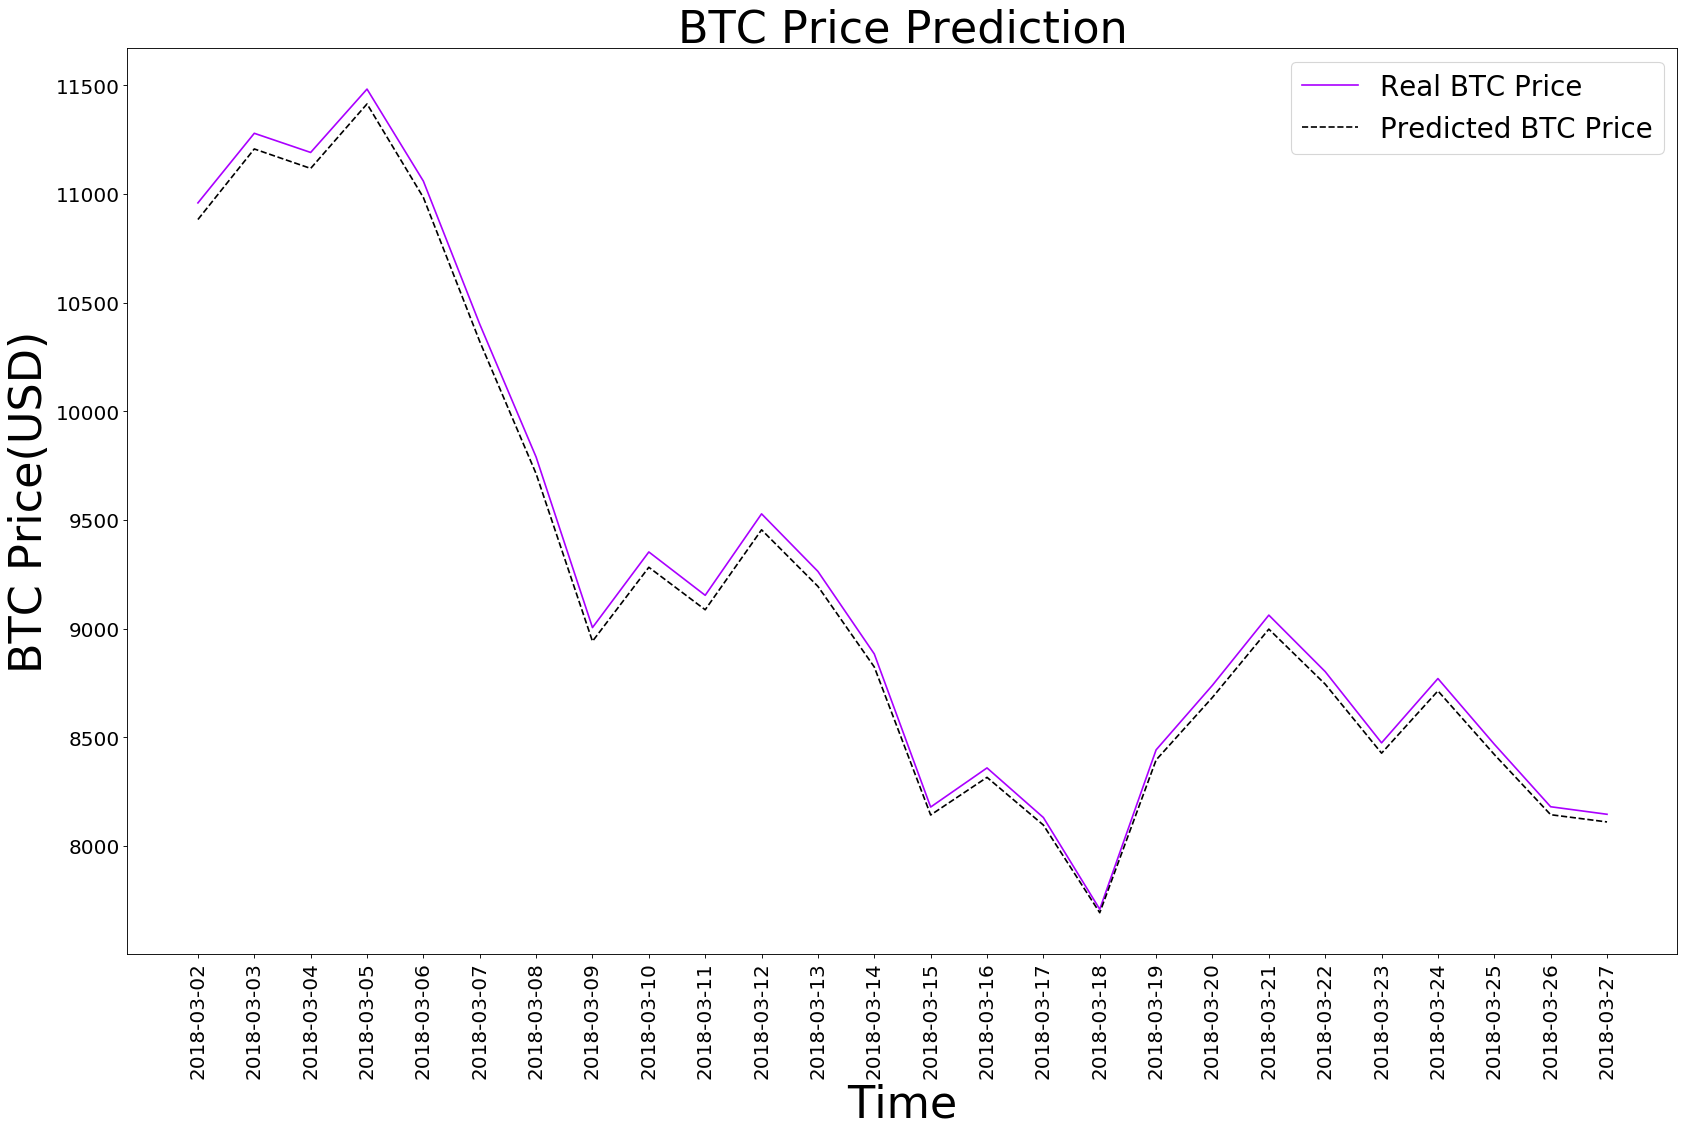

In [248]:
# Visualising the results
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax      = plt.gca()

plt.plot(actual_prices, 
         color = '#AA00FF',
         label = 'Real BTC Price')
plt.plot(predicted_BTC_price,
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted BTC Price')

plt.title('BTC Price Prediction',
          fontsize = 40)

df_test = df_test.reset_index()
x       = df_test.index
labels  = df_test['date']

plt.xticks(x, 
           labels, 
           rotation = 'vertical')

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time',
           fontsize = 40)
plt.ylabel('BTC Price(USD)',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()

Even more interesting than looking at the average daily price prediction is looking at the average percentag

In [249]:
predicted_percent_change = [100*(e2[0] - e1[0])/e1[0] for e1, e2 in zip(predicted_BTC_price[:-1], predicted_BTC_price[1:])]
actual_percent_change    = [100*(e2 - e1)/e1 for e1, e2 in zip(actual_prices[:-1], actual_prices[1:])]

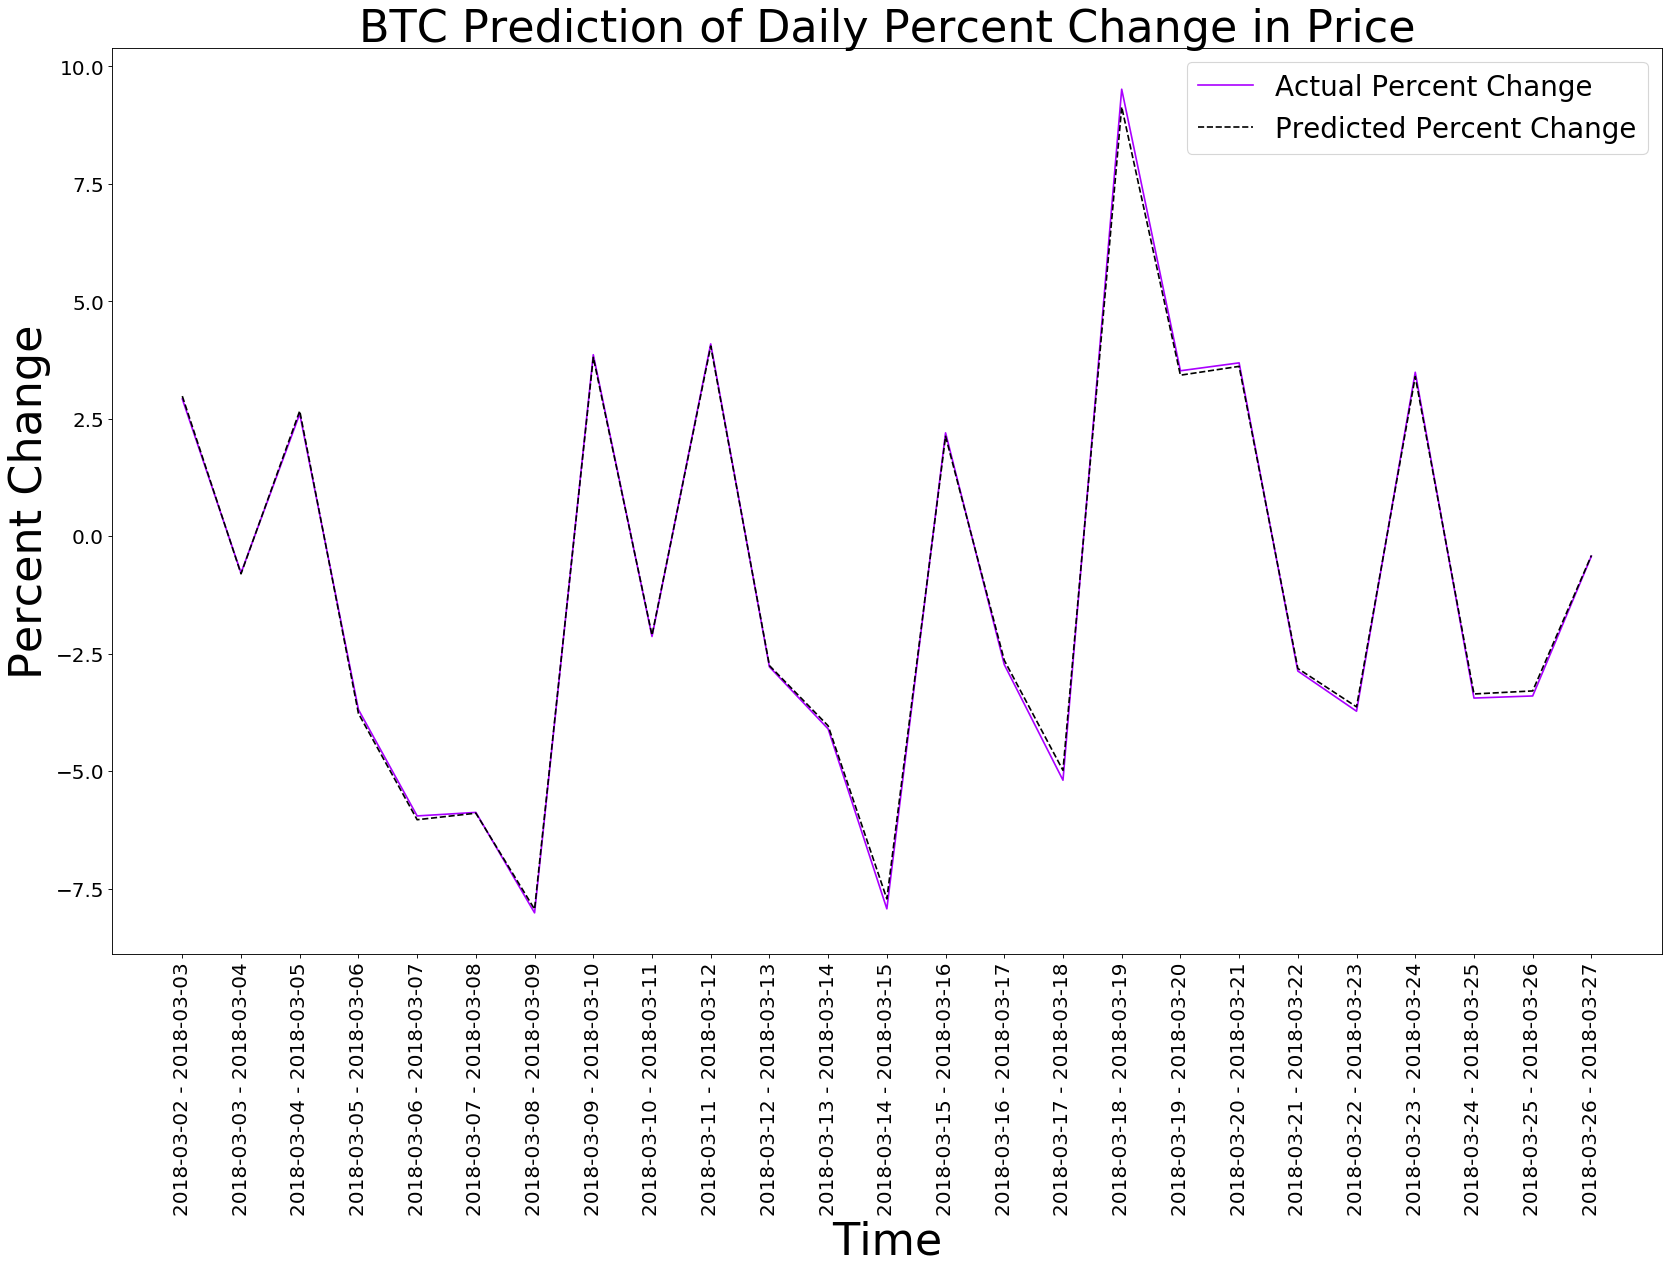

In [250]:
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax      = plt.gca()

plt.plot(actual_percent_change, 
         color = '#AA00FF',
         label = 'Actual Percent Change')
plt.plot(predicted_percent_change,
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted Percent Change')

plt.title('BTC Prediction of Daily Percent Change in Price',
          fontsize = 40)

labels  = [df_test['date'][i].strftime('%Y-%m-%d') + ' - ' + df_test['date'][i + 1].strftime('%Y-%m-%d') for i in range(len(df_test['date']) - 1)]

plt.xticks([_ for _ in range(len(labels))], 
           labels, 
           rotation = 'vertical')

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time',
           fontsize = 40)
plt.ylabel('Percent Change',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()